In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
from numba import jit
from scipy.optimize import brentq

In [104]:
#parameters

mu = 0.34
eta = 0.01
beta = 0.99 #change to 0.99 for final
theta = 0.36
delta = 0.025
rho = 0.9
sigma = 2
nz = 5
nk = 100
tol=1e-10,
maxit=10000

In [105]:
#this is the hw2_ex_v3 code from Rajesh--edit to fit our needs

class Ramsey_Econ602:

    def __init__(self,
                 mu,
                 sigma,
                 beta,
                 theta,
                 delta,
                 rho,
                 eta,
                 nk=100,
                 nz=5,
                 tol=1e-10,
                 maxit=10000):
        
        self.mu = mu
        self.sigma = sigma
        self.beta = beta
        self.theta = theta
        self.delta = delta
        self.rho = rho
        self.eta = eta
        self.nk = nk
        self.nz = nz
        
        # get the state values and transition matrix from the markov chain for z
        self.markov_chain = qe.markov.tauchen(rho, eta, 0, 3, nz)
        self.z_state_values = self.markov_chain.state_values #the formula we're given is ln(z) = rho*ln(z_{-1}) + epsilon_i
        self.transition_matrix = self.markov_chain.P
                                
        #steady state k and l (capital and leisure)
        #these are just to approximate bounds for a linear space that we'll iterate over
        self.ls = (1-theta)/(((1-mu)/mu)+1-theta-((1-mu)/mu)*((delta*theta)/(1/beta-(1-delta))))
        self.ks = self.ls*((1/beta-(1-delta))/theta)**(1/(theta-1))
        
        #need self.kgrid and zgrid because k and z are our state variables
        self.kgrid = np.linspace(0.5*self.ks, 2*self.ks, nk)
        self.zgrid = np.exp(self.z_state_values)

        # Allocate memory--essentially we're just pre-defining the shape of objects we'll pass into functions to fill later
        self.v = np.zeros((nz,nk)) #initial guess for Bellman is zeros
        self.gk_index = np.empty((nz,nk))
        self.gpr = np.empty((nz,nk))
        self.Ret = np.zeros((nz,nk,nk))
        l = np.empty((nz,nk,nk))
        
        #here's where we need to solve for leisure
        
        for z_i in range(nz):
            for k_i in range(nk):
                for k_prime_i in range(nk):
                    kz = (self.kgrid[k_prime_i]-(1-delta)*self.kgrid[k_i])/(self.zgrid[z_i]*(self.kgrid[k_i])**theta)
                    if kz >= 1:
                        l[z_i,k_i,k_prime_i] = 1
                    else:
                        l[z_i,k_i,k_prime_i] = brentq(lambda x: (x**(1-theta))*((1-mu)/mu + 1-theta - (1-theta)/x) - ((1-mu)/mu)*kz,0.0000000001,1)
    
        self.l = l
        
        # compute the return function
        _compute_returns(self.kgrid,self.zgrid,self.delta,self.theta,self.mu,self.sigma,self.l,self.Ret)
                
        # Compute the value function and policy function
        self.solve(tol=tol, maxit=maxit)
        self.kpr_policy()
        self.endog_dist()
   
    # solve is the actual value function iteration
    def solve(self, tol=1e-9, maxit=10000):
        # Iteration Stuff
        it = 0
        dist = 10.

        # Allocate memory to store next iterate of value function
        v_upd = np.zeros((self.nz,self.nk))
        
        # Main loop
        while dist > tol and maxit > it:
            
            self.E_v = np.matmul(self.transition_matrix, self.v)
            
            _inner_loop(self.Ret,self.v,self.E_v,self.beta,self.zgrid,self.kgrid)
            
            dist = np.max(np.abs(v_upd - self.v))
            v_upd[:] = self.v[:]

            it += 1
            if it % 25 == 0:
                print(f"Running iteration {it} with dist of {dist}")

        return None    
        
    # This is to recover policy function after the value function has converged
    
    def kpr_policy(self):
    
    # Compute gpr and its index: best index in kgrid given ik  
        self.gpr = np.empty((self.nz,self.nk))
        self.kgpr = np.empty((self.nz,self.nk))

        self.gpr, self.kgpr = _compute_savings_policy(self.kgrid, self.zgrid, self.Ret, self.v, self.E_v, self.beta, self.gpr, self.kgpr)
        
        print(self.kgpr)
        
    def endog_dist(self):
        self.g = np.zeros((self.nz*self.nk,self.nz*self.nk))
        self.prob = (1/(self.nz*self.nk))*np.ones((self.nz*self.nk))
        self.dist = np.zeros((self.nk))
               
        #_state_t1 finds the state transition matrix g
        self.g = _state_t1(self.transition_matrix,self.gpr,self.g)
        print(self.g)
        
        #this loop should iterate over probabilities until they converge, but it's static. 
        #how do we change probabilities toward convergence? 
        test = 1
        while test > 10**(-10):
            prob1 = self.prob @ self.g
            test = np.max(np.abs(prob1 - self.prob))
            self.prob = prob1
        
        #_state_t2 finds the distribution for capital
        _state_t2(self.nz,self.nk,self.prob,self.dist)
        
        return (self.g,self.prob,self.dist)

# Just to compute utility--need to solve for leisure before this can work        
@jit(nopython=True)
def u(c, l, mu, sigma):
    return (1/(1-sigma))*((c**mu)*((1-l)**(1-mu)))**(1-sigma)

#we need to get the expected value of the bellman by multiplying v(z',k') with the corresponding value in the transition matrix
@jit(nopython=True)
def _inner_loop(Ret,v,E_v,beta,zgrid,kgrid):
    for z_i in range(len(zgrid)):
        for k_i in range(len(kgrid)):
            current_max = -1e14
            for k_prime_i in range(len(kgrid)):
                # m is the Bellman: Ret is utility, and E_v is expected bellman
                m = Ret[z_i,k_i,k_prime_i] + beta * E_v[z_i,k_prime_i]

                if m > current_max:
                    current_max = m      

                v[z_i,k_i] = current_max  
            
    return None

#this will have an nz loop added too
#need the expected value of the Bellman here too
@jit(nopython=True)
def _compute_savings_policy(kgrid,zgrid,Ret,v,E_v,beta,gpr,kgpr):
    for z_i in range(len(zgrid)):
        for k_i in range(len(kgrid)):
            current_max = -1e14
            for k_prime_i in range(len(kgrid)):
                m = Ret[z_i,k_i,k_prime_i] + beta * E_v[z_i,k_prime_i]
                if m > current_max:
                    current_max = m
                    current_max_index = k_prime_i
            gpr[z_i,k_i] = kgrid[current_max_index]
            kgpr[z_i,k_i] = current_max_index
    #print(kgpr)
    return gpr, kgpr
            #add kgpr, consumption, investment, labor, etc--it can all happen here

#this will have an nz loop added too
@jit(nopython=True)
def _compute_returns(kgrid,zgrid,delta,theta,mu,sigma,l,Ret):
    for z_i in range(len(zgrid)):
        for k_i in range(len(kgrid)):
            for k_prime_i in range(len(kgrid)):
                #l_i is just the number corresponding to the z_i, k_i, k_prime_i position in the l matrix
                l_i = l[z_i,k_i,k_prime_i]
                if l_i == 1:
                    Ret[z_i,k_i,k_prime_i] = -1e+14
                else:
                    c = zgrid[z_i]*(kgrid[k_i]**theta)*(l_i**(1-theta))-kgrid[k_prime_i]+(1-delta)*kgrid[k_i]
                    if c <= 0:
                        Ret[z_i,k_i,k_prime_i] = -1e+14
                    else: 
                        Ret[z_i,k_i,k_prime_i] = u(c, l_i, mu, sigma)
    return None

#what is the relationship between capital policy and this?
#@jit(nopython=True)
def _state_t1(Py, kgpr, g):

    g_cols = []
    g_rows = []
    
    for z_i in range(nz):
        for k_i in range(nk):
            g_cols.append((z_i,k_i))
            g_rows.append((z_i,k_i))
            #for z_prime_i in range(nz):

    g = pd.DataFrame(g, columns = g_cols, index = g_rows)
    prob = pd.DataFrame(Py)

    for col in g.columns:
        for row in g.index:
            print(int(kgpr[row]))
            #kgpr[row] is returning 5,10,14,18,18
            if col[1] == int(kgpr[row]):
                g.at[row,col] = prob.at[row[0],col[0]]
    return g
                
#@jit(nopython=True)
def _state_t2(nz,nk,prob,dist):
    
    for iz in range(nz):
        for ik in range(nk):
            dist[ik] = dist[ik] + prob[(iz-1)*nk + ik]
    return None

In [106]:
ramsey = Ramsey_Econ602(mu,
                sigma,
                beta,
                theta,
                delta,
                rho,
                eta,
                nk,
                nz,
                tol=1e-10,
                maxit=10000)

Running iteration 25 with dist of 1.1110496331944262
Running iteration 50 with dist of 0.8518488610875252
Running iteration 75 with dist of 0.6585252621461422
Running iteration 100 with dist of 0.5109201853914414
Running iteration 125 with dist of 0.39695382203058216
Running iteration 150 with dist of 0.30858652756423055
Running iteration 175 with dist of 0.239948749892136
Running iteration 200 with dist of 0.18660552784665185
Running iteration 225 with dist of 0.1451305950009072
Running iteration 250 with dist of 0.11287691403995836
Running iteration 275 with dist of 0.0877935854599059
Running iteration 300 with dist of 0.06828540229321334
Running iteration 325 with dist of 0.053112623949147064
Running iteration 350 with dist of 0.041311481637507086
Running iteration 375 with dist of 0.032132598245681265
Running iteration 400 with dist of 0.024993224393995206
Running iteration 425 with dist of 0.019440152147637946
Running iteration 450 with dist of 0.015120900940729598
Running iterati

18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
1

10
(4, 27)
10
(4, 28)
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
(0, 30)
11
(0, 31)
11
(0, 32)
11
(0, 33)
11
(0, 34)
11
(0, 35)
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
(1, 30)
11
(1, 31)
11
(1, 32)
11
(1, 33)
11
(1, 34)
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
(2, 30)
11
(2, 31)
11
(2, 32)
11
(2, 33)
11
(2, 34)
12


16
(2, 62)
16
(2, 63)
16
(2, 64)
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
(3, 59)
16
(3, 60)
16
(3, 61)
16
(3, 62)
16
(3, 63)
16
(3, 64)
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
(4, 58)
16
(4, 59)
16
(4, 60)
16
(4, 61)
16
(4, 62)
16
(4, 63)
16
(4, 64)
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
(0, 66)
17
(0, 67)
17
(0, 6

14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
(0, 95)
22
(0, 96)
22
(0, 97)
22
(0, 98)
22
(0, 99)
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
(1, 95)
22
(1, 96)
22
(1, 97)
22
(1, 98)
22
(1, 99)
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
(2, 94)
22
(2, 95)
22
(2, 96)
22
(2, 97)
22
(2, 98)
22
(2, 99)
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16


14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7

17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
1

17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
1

15
15
15
15
15
16
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8


14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7


9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19

14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7


17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11

15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9


15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9

9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
(1, 6)
7
(1, 7)
7
(1, 8)
7
(1, 9)
7
(1, 10)
7
(1, 11)
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
(2, 6)
7
(2, 7)
7
(2, 8)
7
(2, 9)
7
(2, 10)
7
(2, 11)
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
(3, 6)
7
(3, 7)
7
(3, 8)
7
(3, 9)
7
(3, 10)
7
(3, 11)
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
1

15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
(4, 34)
12
(4, 35)
12
(4, 36)
12
(4, 37)
12
(4, 38)
12
(4, 39)
12
(4, 40)
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
(0, 42)
13
(0, 43)
13
(0, 44)
13
(0, 45)
13
(0, 46)
13
(0, 47)
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
(1, 42)
13
(1, 43)
13
(1, 44)
13
(1, 45)
13
(1, 46)
13
(1, 47)
14
14
14
14
14
15
15
15
15
15
15
16
16
1

21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
(2, 70)
18
(2, 71)
18
(2, 72)
18
(2, 73)
18
(2, 74)
18
(2, 75)
18
(2, 76)
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
(3, 70)
18
(3, 71)
18
(3, 72)
18
(3, 73)
18
(3, 74)
18
(3, 75)
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
16
17
17
17
17
17
18
(4, 70)
18
(4, 71)
18
(4, 72)
18
(4, 73)
18
(4, 74)
18
(4, 75)
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22

15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8

14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8


9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19


16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10

15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9


16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9


7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
1

18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
1

19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13

8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18

9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18


12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21

22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
(4, 23)
10
(4, 24)
10
(4, 25)
10
(4, 26)
10
(4, 27)
10
(4, 28)
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
(0, 30)
11
(0, 31)
11
(0, 32)
11
(0, 33)
11
(0, 34)
11
(0, 35)
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
(1, 30)
11
(1, 31)
11
(1, 32)
11
(1, 33)
11
(1, 34)
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7

10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
(2, 59)
16
(2, 60)
16
(2, 61)
16
(2, 62)
16
(2, 63)
16
(2, 64)
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
(3, 59)
16
(3, 60)
16
(3, 61)
16
(3, 62)
16
(3, 63)
16
(3, 64)
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
(4, 58)
16
(4, 59)
16
(4, 60)
16
(4, 61)
16
(4, 62)
16
(4, 63)
16
(4, 64)
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11


16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
(0, 95)
22
(0, 96)
22
(0, 97)
22
(0, 98)
22
(0, 99)
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
(1, 95)
22
(1, 96)
22
(1, 97)
22
(1, 98)
22
(1, 99)
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
(2, 94)
22
(2, 95)
22
(2, 96)
22
(2, 97)
22
(2, 98)
22
(2, 99)
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18


11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
21

11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20

11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20

18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
1

6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17


19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13

7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
1

15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8

11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20

9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19


9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
1

19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
(4, 23)
10
(4, 24)
10
(4, 25)
10
(4, 26)
10
(4, 27)
10
(4, 28)
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
(0, 30)
11
(0, 31)
11
(0, 32)
11
(0, 33)
11
(0, 34)
11
(0, 35)
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
(1, 30)
11
(1, 31)
11
(1, 32)
11
(1, 33)
11
(1, 34)
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20

7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
(2, 59)
16
(2, 60)
16
(2, 61)
16
(2, 62)
16
(2, 63)
16
(2, 64)
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
(3, 59)
16
(3, 60)
16
(3, 61)
16
(3, 62)
16
(3, 63)
16
(3, 64)
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
(4, 58)
16
(4, 59)
16
(4, 60)
16
(4, 61)
16
(4, 62)
16
(4, 63)
16
(4, 64)
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
9

13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
(0, 95)
22
(0, 96)
22
(0, 97)
22
(0, 98)
22
(0, 99)
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
(1, 95)
22
(1, 96)
22
(1, 97)
22
(1, 98)
22
(1, 99)
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
(2, 94)
22
(2, 95)
22
(2, 96)
22
(2, 97)
22
(2, 98)
22
(2, 99)
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15


8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18

8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18


8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
1

7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18

6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17


15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9


12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22


19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
1

10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19


9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
1

15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
22
6
(0, 0)
6
(0, 1)
6
(0, 2)
6
(0, 3

11
(3, 33)
11
(3, 34)
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
(4, 29)
11
(4, 30)
11
(4, 31)
11
(4, 32)
11
(4, 33)
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
(0, 36)
12
(0, 37)
12
(0, 38)
12
(0, 39)
12
(0, 40)
12
(0, 41)
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
(1, 35)
12
(1, 36)
12
(1, 37)
12
(1, 38)
12
(1, 39)
12
(1,

17
(1, 67)
17
(1, 68)
17
(1, 69)
17
(1, 70)
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
(2, 65)
17
(2, 66)
17
(2, 67)
17
(2, 68)
17
(2, 69)
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
(3, 65)
17
(3, 66)
17
(3, 67)
17
(3, 68)
17
(3, 69)
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
16
17
(4, 65)
17
(4, 66)
17
(4, 67)
17
(4, 68)
17
(4, 69)
18
18
18

(4, 99)
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16


22
22
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16

22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16

7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17


7
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17

10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20

12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22

22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15

21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14

21
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14

20
21
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14

         (0, 0)  (0, 1)  (0, 2)  (0, 3)  (0, 4)  (0, 5)    (0, 6)  (0, 7)  \
(0, 0)      0.0     0.0     0.0     0.0     0.0     0.0  0.849051     0.0   
(0, 1)      0.0     0.0     0.0     0.0     0.0     0.0  0.849051     0.0   
(0, 2)      0.0     0.0     0.0     0.0     0.0     0.0  0.849051     0.0   
(0, 3)      0.0     0.0     0.0     0.0     0.0     0.0  0.849051     0.0   
(0, 4)      0.0     0.0     0.0     0.0     0.0     0.0  0.849051     0.0   
...         ...     ...     ...     ...     ...     ...       ...     ...   
(4, 95)     0.0     0.0     0.0     0.0     0.0     0.0  0.000000     0.0   
(4, 96)     0.0     0.0     0.0     0.0     0.0     0.0  0.000000     0.0   
(4, 97)     0.0     0.0     0.0     0.0     0.0     0.0  0.000000     0.0   
(4, 98)     0.0     0.0     0.0     0.0     0.0     0.0  0.000000     0.0   
(4, 99)     0.0     0.0     0.0     0.0     0.0     0.0  0.000000     0.0   

         (0, 8)  (0, 9)  ...  (4, 90)  (4, 91)  (4, 92)  (4, 93)  (4, 94)  

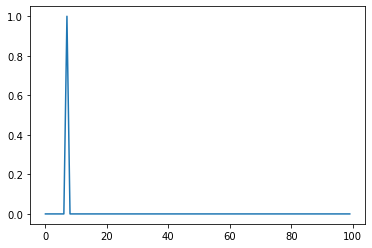

In [107]:
print(pd.DataFrame(ramsey.g))
print(pd.DataFrame(ramsey.prob))
print(pd.DataFrame(ramsey.dist))
print(pd.DataFrame(ramsey.kgpr))

plt.plot(ramsey.dist) #all the mass is concentrated at 7

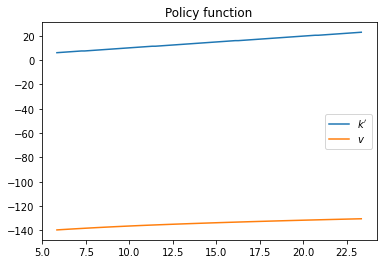

In [108]:
#need these to be 3d
fig, ax = plt.subplots()
ax.set_title("Policy function")

    
ax.plot(ramsey.kgrid, ramsey.gpr[0], label="$k'$")
ax.legend()

ax.plot(ramsey.kgrid, ramsey.v[0], label="$v$")
ax.legend()
plt.show()

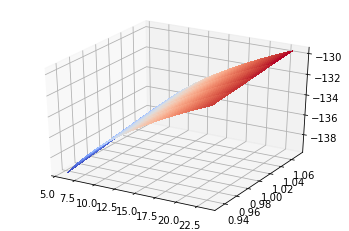

In [111]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
xx, yy = ramsey.kgrid, ramsey.zgrid 
X, Y = np.meshgrid(xx, yy)
Z = ramsey.v #v is value and gpr is saving policy

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

plt.show()

In [ ]:
"""#this gets us the G matrix

print(pd.DataFrame(ramsey.transition_matrix, index = ['z1','z2','z3'], columns = ['z1','z2','z3']))
print(pd.DataFrame(ramsey.gpr, index = ['z1','z2','z3'], columns = ['k1','k2','k3']))
G = np.zeros((ramsey.transition_matrix.shape[0]*ramsey.transition_matrix.shape[1],
              ramsey.transition_matrix.shape[0]*ramsey.transition_matrix.shape[1]))

g_cols = []
g_rows = []

for z_i in range(nz):
    for k_i in range(nk):
        g_cols.append((z_i,k_i))
        g_rows.append((z_i,k_i))
        #for z_prime_i in range(nz):
            

G = pd.DataFrame(G, columns = g_cols, index = g_rows)

prob = pd.DataFrame(ramsey.transition_matrix)

for col in G.columns:
    for row in G.index:
        if col[1] == row[1]:
            G.at[row,col] = prob.at[row[0],col[0]]
            
G.round(decimals = 4)"""

In [ ]:
"""    nz,nk = kgpr.shape
    
    g_cols = []
    g_rows = []

    for z_i in range(nz):
        for k_i in range(nk):
            g_cols.append((z_i,k_i))
            g_rows.append((z_i,k_i))
            #for z_prime_i in range(nz):


    g = pd.DataFrame(g, columns = g_cols, index = g_rows)

    prob = pd.DataFrame(Py)

    for col in g.columns:
        for row in g.index:
            #print(row,kgpr[row])
            if col[1] == int(kgpr[row]):
                print(row)
                self.g.at[row,col] = prob.at[row[0],col[0]]"""